In [1]:
'''
Script no 2.

this is a the script to perform eye disease clasification using deep learning
~ ssmj

in this script we will do the following :
1) dependencies installation
2) using the classsification algo here
3) training the model
4) making it ready for api integration
'''

'\nScript no 2.\n\nthis is a the script to perform eye disease clasification using deep learning\n~ ssmj\n\nin this script we will do the following :\n1) dependencies installation\n2) using the classsification algo here\n3) training the model\n4) making it ready for api integration\n'

In [2]:
# dependenices
!pip install opencv-python-headless
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import base64
import io
from PIL import Image
from collections import Counter
#splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#training
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import io
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

print("SUCCESS")

SUCCESS


In [3]:
#fetch ds

drive.mount('/content/drive')
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/X_train.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/y_train.npy")

X_val = np.load("/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/X_val.npy")
y_val = np.load("/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/y_val.npy")

X_test = np.load("/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/X_test.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/y_test.npy")


def sizeCal(x):
  print(x.shape)
sizeCal(X_train)
sizeCal(y_train)
sizeCal(X_val)
sizeCal(y_val)
sizeCal(X_test)
sizeCal(y_test)

Mounted at /content/drive
(2951, 224, 224, 3)
(2951, 4)
(633, 224, 224, 3)
(633, 4)
(633, 224, 224, 3)
(633, 4)


In [5]:
# applying the ALGO HERE

# Loading ResNet50 base mod (exclude top)
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze base model layers (for feature extraction)
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Build custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)

from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

output = Dense(4, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

In [6]:
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
hist = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=20,
          batch_size=32,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(patience=2)
          ])


Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 137s 727ms/step - accuracy: 0.5917 - loss: 1.7543 - val_accuracy: 0.2464 - val_loss: 28.5431 - learning_rate: 5.0000e-04
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 337ms/step - accuracy: 0.8502 - loss: 1.1528 - val_accuracy: 0.2464 - val_loss: 15.1901 - learning_rate: 5.0000e-04
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 330ms/step - accuracy: 0.9017 - loss: 0.9532 - val_accuracy: 0.2464 - val_loss: 9.1942 - learning_rate: 5.0000e-04
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 330ms/step - accuracy: 0.9010 - loss: 0.9043 - val_accuracy: 0.2464 - val_loss: 8.8578 - learning_rate: 5.0000e-04
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - accuracy: 0.9358 - loss: 0.7770 - val_accuracy: 0.2464 - val_loss: 6.4169 - learning_rate: 5.0000e-04
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 330ms/step - accuracy: 0.9110 - loss: 0.7992 - val_accuracy: 0.2464 - val_loss: 7.1171 - learning_rate: 5.0000e-04
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 337ms/step - 

In [8]:
y_pred_probs = model.predict(X_test)

# Get class predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step


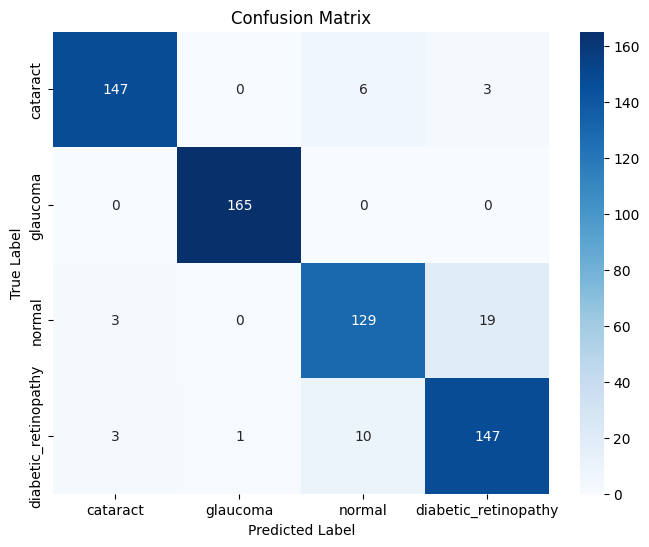

In [9]:
#confusion mat
class_names = ['cataract', 'glaucoma', 'normal', 'diabetic_retinopathy']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


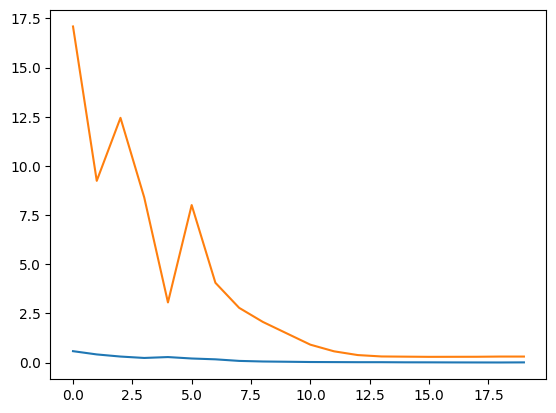

In [ ]:
# Plot Loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')